In [5]:
import numpy as np
import pandas as pd
import tensorflow as tr
from tensorflow import keras
import os
import matplotlib.image as mpimg

# VALIDATE DATA
Ensuring files and Sheets have equal values


In [6]:
test_files=[]

file =pd.read_csv("data/test_meta.csv")
#file paths
test_dir="data/test/"
train_dir="data/train/"
#meta record paths
meta_train_dir="data/train_meta.csv"
meta_test_dir="data/test_meta.csv"
#original record paths
org_train_dir=""
org_test_dir=""


def compareFiles(file_path,record_path):
    #prepare sheets
    data = pd.DataFrame(pd.read_csv(record_path))
    # data.head()
    names = data['image_id'] 
    count =0
    # compare png files and records in the Excel sheets
    with os.scandir(file_path)as files:
        for file in files:
            if(str(file.name)!=str(names[count])+".png"):
                print("Inconsistent on line "+str(count)+" for image "+str(file.name)+" and record "+str(names[count])+".png")
            count+=1  
    # Records v files may not be equal
    if(count==len(names)):
        print("Files and folders are equal")
        print(str(count)+" "+str(len(names))) 
    elif(count<len(names)):
        print("File missing")
        print("Files: "+str(count)+" Records: "+str(len(names)))
    elif(count>len(names)):
        print("Record missing")
        print("Files: "+str(count)+" Records: "+str(len(names)))
    

compareFiles(test_dir,meta_test_dir)
compareFiles(train_dir,meta_train_dir)


Files and folders are equal
3000 3000
Files and folders are equal
15000 15000


In [7]:
#png dataset
test_dir="data/test/"
train_dir="data/train/"
#original dicom dataset
org_train_dir="data/original/train"
org_test_dir="data/original/test"
#png datasize same resolution as dicom dataset
variant_dir="data/variant"

Files found:1


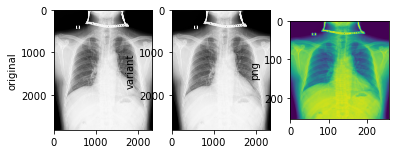

In [69]:
# preprocessing 
# def image-processor(image, size):
# Set mean image size as desired image size for all images in the img list
# Make images black and white  
# def image-processor(image, coords):
# Compare original images and currnet images b-box

#key = 000434271f63a053c4128a0ba6352c7f
#search dir for img matching{----} and draw the b-box on
from os import O_RDONLY
from matplotlib import pyplot as plt

import pydicom as pdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def search(key):
    count = 0
    files = os.scandir(train_dir)
    ax, (fig1, fig2, fig3) = plt.subplots(1,3)
    for file in files:
        if(str(file.name)==key+".png"):
            dicom = pdm.dcmread(org_train_dir+"/"+str(key)+".dicom")
            fig1.imshow(dicom.pixel_array,cmap=plt.cm.Greys)
            fig1.set_ylabel("original")

            fig2.imshow(mpimg.imread(variant_dir+"/"+key+".png"),cmap=plt.cm.Greys_r)
            fig2.set_ylabel("variant")

            fig3.imshow(mpimg.imread(train_dir+"/"+key+".png"))
            fig3.set_ylabel("png")
            # ax.plot(fig1,fig2)
           
            count+=1
            print("Files found:"+ str(count))
            plt.show()
    if(count==0):
        print(count)
        print("no file found")

search(key = "000434271f63a053c4128a0ba6352c7f")


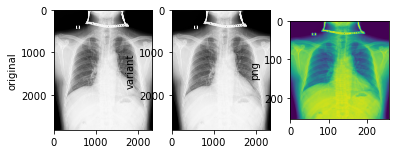

In [60]:
test_dir="data/test/"
train_dir="data/train/"

org_train_dir="data/original/train"
org_test_dir="data/original/test"

variant_dir="data/variant"

import pydicom as pdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#convert from dicom to png
key ="000434271f63a053c4128a0ba6352c7f"
#read the dicom image using pydicom as pdm
ax, (fig1, fig2, fig3) = plt.subplots(1,3)
dicom = pdm.dcmread(org_train_dir+"/"+key+".dicom")
fig1.imshow(dicom.pixel_array,cmap=plt.cm.Greys)
fig1.set_ylabel("original")

fig2.imshow(mpimg.imread(variant_dir+"/"+key+".png"),cmap=plt.cm.Greys_r)
fig2.set_ylabel("variant")

fig3.imshow(mpimg.imread(train_dir+"/"+key+".png"))
fig3.set_ylabel("png")
# ax.plot(fig1,fig2)
plt.show()


In [70]:
#drawing coords using matplotlib patches
